This is the code used for the remote implementation of the three-class classification of images in benign, low Gleason grade and high Gleason grade  classes. 

For the code to run the dataset.csv file of dataset D should be located at the path  '/content/drive/MyDrive/223B/path_256_1_new/data/dataset.csv'; and the images of the dataset D should be inside the folder at the path '/content/drive/MyDrive/223B/normal_256_1_new/'.

The se en cells of this notebook roughly implement the following pipeline:
- create matrices for the images and for the label of the train, val, test sets
- covert to categorical, normalize pixel values, and decide whether to subtract mean
- define a function that creates a DenseNet, and a function that prints the  learning rate at the end of each epoch
- perform grid search for hyperparameters
- create a t-SNE plot with PCA preprocessing
- perform manual err analysis
- plot confusion matrix at the tile level, and then at the patient level.




Mounted at /content/drive
0  :  7508_4480_24192     4+5
1  :  7508_124544_20608     4+5
2  :  7508_46592_25984     4+5
3  :  7508_4480_23296     4+5
4  :  7508_46592_26880     4+5
5  :  7508_125440_19712     4+5
6  :  7508_45696_25088     4+5
7  :  7508_45696_24192     4+5
8  :  7508_5376_21504     4+5
9  :  7508_5376_23296     4+5
10  :  7022_24192_22400     4+5
11  :  7022_110208_25088     4+5
12  :  7022_33152_16128     4+5
13  :  7022_30464_17920     4+5
14  :  7022_115584_19712     4+5
15  :  7022_25088_24192     4+5
16  :  7022_109312_23296     4+5
17  :  7022_30464_18816     4+5
18  :  7022_24192_24192     4+5
19  :  7022_32256_18816     4+5
20  :  3937_39424_39424     3+3
21  :  3937_39424_36736     3+3
22  :  3937_112896_46592     3+3
23  :  3937_112000_43008     3+3
24  :  3937_111104_42112     3+3
25  :  3937_112000_45696     3+3
26  :  3937_112896_45696     3+3
27  :  3937_41216_39424     3+3
28  :  3937_38528_35840     3+3
29  :  3937_38528_37632     3+3
30  :  3211_5376_3

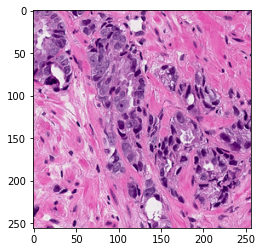

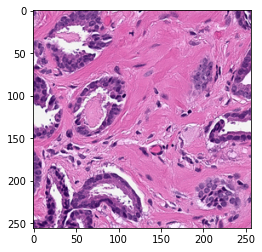

Data loaded
600 150 250


In [ ]:
#based off https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_06_3_resnet.ipynb

# from __future__ import print_function
import tensorflow as tf
import math
import tensorflow.keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
from tensorflow.keras.layers import Dense, Conv2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.applications.densenet import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as Image
from six.moves import cPickle 
import time
from datetime import datetime
import numpy as np
import os
import pandas
from keras.models import load_model

# from IPython.display import Image


from google.colab import drive
drive.mount('/content/drive')

pandas.options.mode.chained_assignment = None


images = []

csv_location_new = '/content/drive/MyDrive/223B/path_256_1_new/data/dataset.csv'
data_new = pandas.read_csv(csv_location_new)
labels_new = data_new.label

#location_images = '/content/drive/MyDrive/223B/path_256_1_new/'
location_images = '/content/drive/MyDrive/223B/normal_256_1_new/'
SUBTRACT_PIXEL_MEAN = False


count=0
for x in data_new.tile_name:
    print(count,' : ', x, '   ', labels_new[count])
    images.append(np.array(Image.imread(os.path.join( location_images  ,x + '.png'))))
    count +=1

for x in range(len(labels_new)):
    if labels_new[x] == '0+0':
        labels_new[x] = 0
    elif labels_new[x] == '3+3':
        labels_new[x] = 1
    else:
        labels_new[x] = 2
labels = labels_new.array

TRAIN_idx = 1800
VALTEST_idx = 2400


imgplot = plt.imshow(images[1000])
plt.show()
imgplot = plt.imshow(images[2528])
plt.show()




images = np.array(images,dtype=np.uint32) 

print("Data loaded")

#Load the data.
x_train = images[:TRAIN_idx]
x_val = images[TRAIN_idx:VALTEST_idx]
x_test = images[VALTEST_idx:]
y_train = labels[:TRAIN_idx]
y_val = labels[TRAIN_idx:VALTEST_idx]
y_test = labels[VALTEST_idx:] 

# x_train = images[:600]
# x_val = images[600:800]
# x_test = images[800:1000]
# y_train = labels[:600]
# y_val = labels[600:800]
# y_test = labels[800:1000] 

print( np.count_nonzero(y_train == 1),  np.count_nonzero(y_val == 1), np.count_nonzero(y_test == 1) )

def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m:>02}:{s:>05.2f}"
    



In [ ]:
# # parameters
# BATCH_SIZE = 7 #high batch size = memory failure
# EPOCHS = 35
# USE_AUGMENTATION = True
# num_classes = np.unique(y_train).shape[0] 
# #num_classes = 2
# LR = 5e-5
# droprate = 0.05
# #OPTIMIZER = SGD(lr=LR, nesterov = True)
# OPTIMIZER = Adam(lr=LR)
# DEPTH = 110
# num_units = 256
# initializer = 'he_normal'  # 'he_uniform' #  # "glorot_uniform"


In [ ]:
#define number of classes for classification
num_classes = np.unique(y_train).shape[0] 

# Input image dimensions.
input_shape = x_train.shape[1:]

# Normalize data.
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# If subtract pixel mean is enabled
if SUBTRACT_PIXEL_MEAN:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_val -= x_train_mean
    x_test -= x_train_mean

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_val.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = tensorflow.keras.utils.to_categorical(y_train, num_classes)
y_val = tensorflow.keras.utils.to_categorical(y_val, num_classes)
y_test = tensorflow.keras.utils.to_categorical(y_test, num_classes)

x_train shape: (1800, 256, 256, 3)
1800 train samples
600 test samples
y_train shape: (1800,)


In [ ]:
def Create_Model(weights_imagenet, layers, num_units, droprate, pool_dim=3, n_classes=1, input_shape=(224,224,3) ):

    if weights_imagenet:
      weights = 'imagenet'
    else:
      weights = None

    if layers==121:
      base_model = DenseNet121(weights=weights, include_top=False, input_shape=input_shape)
    elif layers==169:
      base_model = DenseNet169(weights=weights, include_top=False, input_shape=input_shape)
    else:
      base_model = DenseNet201(weights=weights, include_top=False, input_shape=input_shape)
    
    x = base_model.output
    x = AveragePooling2D(pool_size=(pool_dim,pool_dim), name='avg_pool')(x)
    x = Flatten()(x)
    x = Dense(num_units, activation='relu', name='dense_post_pool')(x)
    x = Dropout(droprate)(x)
    output = Dense(n_classes, activation='softmax', name='predictions')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model


class logCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    lr = K.get_value(self.model.optimizer.lr)
    val_acc = logs['val_accuracy']
    val_loss = logs['val_loss']
    print("Learning rate:", lr)	
    #print("Learning rate:", lr, "Val Accuracy:", val_acc, "Val Loss:", val_loss)		

|   iter    |  target   | BATCH_... |  EPOCHS   |    LR     |  dropout  | num_units |
-------------------------------------------------------------------------------------
Using real-time data augmentation.
break
Learning rate: 1.1142604425275418e-06  Accuracy: 0.4000000059604645  Loss: 1.127008318901062
Learning rate: 1.1142604425275418e-06  Accuracy: 0.4000000059604645  Loss: 1.1188970804214478
Learning rate: 1.1142604425275418e-06  Accuracy: 0.4000000059604645  Loss: 1.0971125364303589
Learning rate: 1.1142604425275418e-06  Accuracy: 0.38499999046325684  Loss: 1.107814908027649
Learning rate: 1.1142604425275419e-07  Accuracy: 0.3400000035762787  Loss: 1.0977718830108643
Learning rate: 1.1142604425275419e-07  Accuracy: 0.35333332419395447  Loss: 1.085955023765564
Learning rate: 1.1142604425275419e-07  Accuracy: 0.35333332419395447  Loss: 1.0929476022720337
Learning rate: 1.1142604425275419e-08  Accuracy: 0.36000001430511475  Loss: 1.094240665435791
Learning rate: 1.1142604425275419e-

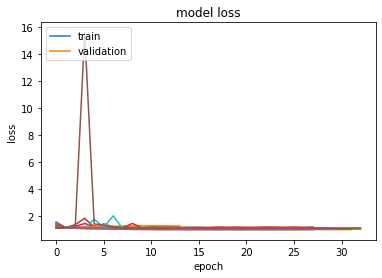

In [ ]:
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization
import time

# Supress NaN warnings
import warnings
warnings.filterwarnings("ignore",category =UserWarning)

import warnings
warnings.filterwarnings("ignore",category =RuntimeWarning)

# Bounded region of parameter space
pbounds = {'dropout': (0.05, 0.3), 
            'BATCH_SIZE': (5, 5),
            'EPOCHS': (60, 60),
           'LR': (1e-6, 1e-2),
           'num_units': (1024,1024),
           }



optimizer = BayesianOptimization(
    f=evaluate_network,
    pbounds=pbounds,
    verbose=2,  # verbose = 1 prints only when a maximum 
    # is observed, verbose = 0 is silent
    random_state=1,
)

start_time = time.time()
optimizer.maximize(init_points=10, n_iter=3,)
time_took = time.time() - start_time

print(time_took)
#print(f"Total runtime: {hms_string(time_took)}")
print(optimizer.max)

In [ ]:
# droprate = 0.8
# num_units = 1024
# LR = 0.001
# EPOCHS = 45
# OPTIMIZER = SGD(lr=LR)
# BATCH_SIZE = 5 
# weights_imagenet = True
# layers = 201
# pool_dim=3
# USE_AUGMENTATION = True

best_imagenet = None
best_val_acc = 0
best_LR = 0
best_pool_dim = 0
best_layers = 0
best_droprate = 0
best_optimi = None
num_units = 1024

# droprate = 0.5
# num_units = 1024
# LR = 0.0003
# EPOCHS = 70
# OPTIMIZER = RMSprop(lr=LR)
# BATCH_SIZE = 5 
# weights_imagenet = True
# layers = 169
# pool_dim=3
# USE_AUGMENTATION = True

BATCH_SIZE = 5 
USE_AUGMENTATION = True
EPOCHS = 70

#imagenet True; LR 3e-05; layers 201; pool_dim 3; droprate 0.5; optimi RMSprop


for weights_imagenet in [True]:
  for LR in [ 0.00001]:
    for layers in [ 201]:
      for pool_dim in [3]:
        for droprate in [0.5]:
          for optimi in ['RMSprop']:

            if optimi=='Adam':
              OPTIMIZER = Adam(lr=LR)
            elif optimi=='SGD':
              OPTIMIZER = SGD(lr=LR)
            elif optimi=='RMSprop':
              OPTIMIZER = RMSprop(lr=LR)
            
            print(  'imagenet {}; LR {}; layers {}; pool_dim {}; droprate {}; optimi {}'.format(weights_imagenet, LR, layers, pool_dim, droprate, optimi)  )

            model_new = Create_Model(weights_imagenet, layers, num_units, droprate, pool_dim, num_classes, input_shape )

            model_new.compile(loss='categorical_crossentropy',
                          optimizer=OPTIMIZER,
                          metrics=['accuracy', 'AUC'])
            #model_new.summary()

            y_pred = model_new.predict(x_test)

            start_time = time.time()

            # Prepare callbacks for model saving and for learning rate adjustment.

            lr_reducer = ReduceLROnPlateau(factor=0.1, cooldown=0, patience=4)

            earl_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=16)
                            
            # def decay_schedule(epoch, lr):
              # if (epoch < 58) and (lr > 1e-6):
                # lr *= 0.9
              # elif (epoch > 58):
                # lr *= 0.9
              # return lr
              
            # lr_scheduler = LearningRateScheduler(decay_schedule)
                            
            #callbacks = [earl_stop, logCallback()]

            callbacks = [lr_reducer, earl_stop, logCallback()]

            # Run training, with or without data augmentation.
            if not USE_AUGMENTATION:
                print('Not using data augmentation.')
                history = model_new.fit(x_train, y_train,
                          batch_size=BATCH_SIZE,
                          epochs=EPOCHS,
                          validation_data=(x_val, y_val),
                          shuffle=True,
                          callbacks=callbacks)
            else:
                print('Using real-time data augmentation.')
                # This will do preprocessing and realtime data augmentation:
                datagen = ImageDataGenerator(
                    # set input mean to 0 over the dataset
                    featurewise_center=False,
                    # set each sample mean to 0
                    samplewise_center=False,
                    # divide inputs by std of dataset
                    featurewise_std_normalization=False,
                    # divide each input by its std
                    samplewise_std_normalization=False,
                    # apply ZCA whitening
                    zca_whitening=False,
                    # epsilon for ZCA whitening
                    zca_epsilon=1e-06,
                    # randomly rotate images in the range (deg 0 to 180)
                    rotation_range=180,
                    # randomly shift images horizontally
                    width_shift_range=0.1,
                    # randomly shift images vertically
                    height_shift_range=0.1,
                    # set range for random shear
                    shear_range=0.,
                    # set range for random zoom
                    zoom_range=0.,
                    # set range for random channel shifts
                    channel_shift_range=0.,
                    # set mode for filling points outside the input boundaries
                    fill_mode='nearest',
                    # value used for fill_mode = "constant"
                    cval=0.,
                    # randomly flip images
                    horizontal_flip=True,
                    # randomly flip images
                    vertical_flip=True,
                    # set rescaling factor (applied before any other transformation)
                    rescale=None,
                    # set function that will be applied on each input
                    preprocessing_function=None,
                    # image data format, either "channels_first" or "channels_last"
                    data_format=None,
                    # fraction of images reserved for validation 
                    # (strictly between 0 and 1)
                    validation_split=0.0)

                # Compute quantities required for featurewise normalization
                # (std, mean, and principal components if ZCA whitening is applied).
                datagen.fit(x_train)

                # Fit the model on the batches generated by datagen.flow().
                history = model_new.fit_generator(datagen.flow(x_train, y_train, 
                                      batch_size=BATCH_SIZE),
                                      validation_data=(x_val, y_val),
                                      epochs=EPOCHS, verbose=1,
                                      shuffle=True,
                                      callbacks=callbacks)
                

            elapsed_time = time.time() - start_time
            print("Elapsed time: {}".format(hms_string(elapsed_time)))


            #plots
            # summarize history for accuracy
            plt.plot(history.history['accuracy'])
            plt.plot(history.history['val_accuracy'])
            plt.title('model accuracy')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'val'], loc='upper left')
            plt.show()
            # summarize history for loss
            plt.plot(history.history['loss'])
            plt.plot(history.history['val_loss'])
            plt.title('model loss')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'val'], loc='upper left')
            plt.show()

            scores = model_new.evaluate(x_val, y_val, verbose=1)
            print('val_acc is', scores[1])
            if best_val_acc < scores[1]:
              best_val_acc = scores[1]
              best_imagenet = weights_imagenet
              best_LR = LR
              best_pool_dim = pool_dim
              best_layers = layers
              best_droprate = droprate
              best_optimi = optimi 
              #model_new.save('model_3classes_n.h')


            #model_best, loss, accuracy = create_train_return_model(num_units, BATCH_SIZE, EPOCHS, dropout, LR)
            #evaluate_network( BATCH_SIZE, EPOCHS, dropout, lr_initial)

            scores = model_new.evaluate(x_test, y_test, verbose=1)
            print('Test loss:', scores[0])
            print('Test accuracy:', scores[1])
    
print(  'best imagenet {}; LR {}; best layers {}; best pool_dim {}; best droprate {}; best optimi {}'.format(weights_imagenet, best_LR, best_layers, best_pool_dim, best_droprate, best_optimi)  )



imagenet True; LR 1e-05; layers 201; pool_dim 3; droprate 0.5; optimi RMSprop
74842112/74836368 [==============================] - 1s 0us/step
Using real-time data augmentation.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/70
360/360 [==============================] - 85s 133ms/step - loss: 1.4004 - accuracy: 0.3485 - auc: 0.5313 - val_loss: 1.2211 - val_accuracy: 0.4000 - val_auc: 0.5093
Learning rate: 1e-05
Epoch 2/70
360/360 [==============================] - 45s 124ms/step - loss: 1.1910 - accuracy: 0.4352 - auc: 0.6073 - val_loss: 1.4897 - val_accuracy: 0.4033 - val_auc: 0.5283
Learning rate: 1e-05
Epoch 3/70
360/360 [==============================] - 45s 123ms/step - loss: 1.0809 - accuracy: 0.4611 - auc: 0.6600 - val_loss: 1.1661 - val_accuracy: 0.4317 - val_auc: 0.6130
Learning rate: 1e-05
Epoch 4/70
360/360 [==============================] - 44s 123ms/step - loss: 1.0294 - accuracy: 0.4978 - auc: 0.6912 - val_loss: 0.9743 - val_accuracy: 0.5433 - val_auc: 0.7127
Learning rate: 1e-05
Epoch 5/70
360/360 [==============================] - 44s 123ms/step - loss: 0.9874 - accuracy: 0.5147 - auc: 0.7074 - val_loss: 0.9721 - val_accuracy: 0.5150 - val_auc: 0.7126
Learning rate: 1e-05
Epoch 6/70

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

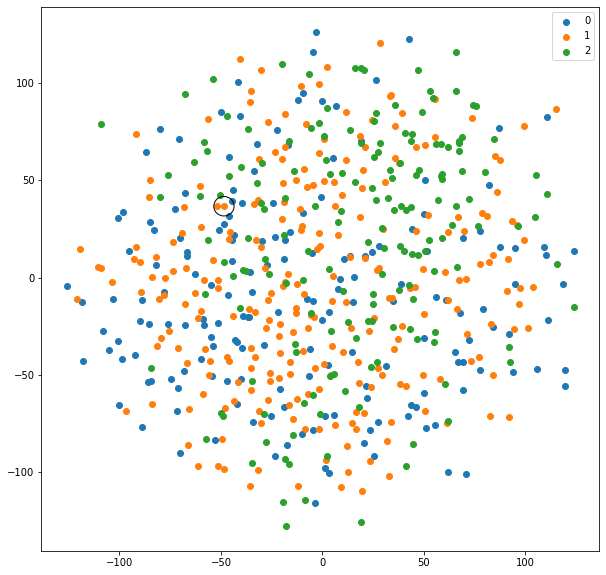

In [ ]:
from matplotlib import pyplot
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


#model_best = load_model('model_3classes.h')
model_best = model_new
model_best.summary()

print(model_best.layers[704].name)



# redefine model to output right after the first hidden layer

# feat_extr_model = Model(inputs=model_best.inputs,  outputs=model_best.get_layer('conv5_block32_2_conv').output )
feat_extr_model = Model(inputs=model_best.inputs,  outputs=model_best.get_layer('relu').output )
hidden_features = feat_extr_model.predict(x_test)
hidden_features = hidden_features.reshape( (600, 8*8*1920)  )

print('shape of hidden_features is ', np.shape(hidden_features) )

pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)
print('Variance PCA: {}'.format(np.sum(pca.explained_variance_ratio_)))

tsne = TSNE(n_components=3, n_iter = 1000, n_iter_without_progress = 100, perplexity = 70.0, verbose = 1)
tsne_results = tsne.fit_transform(pca_result)

color_map = np.argmax(y_test, axis=1)
fig = plt.figure(figsize=(10,10))
for cl in range(3):
    indices = np.where(color_map==cl)
    #print(indices)
    indices = indices[0]
    #print(indices)
    plt.scatter(tsne_results[indices,0], tsne_results[indices, 1], label=cl)

circle=plt.Circle( (tsne_results[128,0], tsne_results[128, 1]), 5, color='black', fill=False)
ax = fig.gca()
ax.add_patch(circle)
plt.legend()
plt.show()


In [ ]:
# plot information for manual err analysis


wrong_ct = 0
wrong_list = []
one_as_2_ct = 0

for i in range(np.shape(y_test)[0]):
  x1 = x_test[i,:,:,:]
  y1 = y_test[i]
  x1 = x1.reshape( (1,256,256,3))
  if np.argmax(model_best.predict(x1)[0]) != np.argmax(y1):
    print(i, model_best.predict(x1)[0], np.argmax(model_best.predict(x1)[0]), np.argmax(y1) )
    #print(model_best.predict(x1)[0], y1 )
    #print(i)
    wrong_list.append(i)
    wrong_ct +=1
    if np.argmax(y1)==1 and np.argmax(model_best.predict(x1)[0])==2:
      one_as_2_ct += 1



print(one_as_2_ct/600)
print(wrong_ct/600)
print(wrong_list)




0 [0.44698885 0.46422794 0.08878314] 1 2
1 [0.18974517 0.4948376  0.3154172 ] 1 2
12 [0.14596555 0.42249334 0.43154117] 2 0
15 [0.38782609 0.19393364 0.4182403 ] 2 0
22 [0.27029797 0.31787273 0.4118293 ] 2 1
26 [0.11451651 0.41677907 0.4687044 ] 2 1
27 [0.77737486 0.16635397 0.05627121] 0 1
37 [0.42046732 0.35488376 0.22464894] 0 2
40 [0.130387   0.39710385 0.47250915] 2 1
41 [0.08488084 0.35398215 0.561137  ] 2 1
44 [0.1053775  0.33112285 0.5634996 ] 2 1
45 [0.05102473 0.4190033  0.52997196] 2 1
46 [0.45214713 0.34859234 0.19926052] 0 1
47 [0.16176656 0.38299194 0.4552414 ] 2 1
48 [0.13765036 0.40654615 0.4558035 ] 2 1
52 [0.4604598  0.3748563  0.16468391] 0 1
53 [0.14062317 0.38313082 0.47624597] 2 1
57 [0.07972485 0.37102506 0.54925007] 2 1
70 [0.06349303 0.20097269 0.73553425] 2 1
71 [0.10538945 0.20185329 0.69275725] 2 1
72 [0.14705153 0.32457012 0.52837837] 2 1
73 [0.05110109 0.08909384 0.85980505] 2 1
74 [0.04158822 0.19241399 0.76599777] 2 1
75 [0.16842088 0.14404905 0.68753004

[[0.44698885 0.46422783 0.08878323]
 [0.18974492 0.49483737 0.31541765]
 [0.11569539 0.2940343  0.59027034]
 ...
 [0.22427143 0.40653968 0.3691889 ]
 [0.24363834 0.37128356 0.38507804]
 [0.11151185 0.45804757 0.43044055]]
[0.44698885 0.46422783 0.08878323]
[1 1 2 2 2 2 2 2 2 2 0 0 2 0 0 2 0 0 0 0 1 1 2 1 1 1 2 0 1 1 2 2 2 2 2 2 2
 0 2 2 2 2 1 1 2 2 0 2 2 1 1 1 0 2 1 1 1 2 1 1 0 0 0 0 0 0 0 0 0 0 2 2 2 2
 2 2 2 2 2 2 1 0 0 0 0 0 0 0 1 0 2 1 2 1 1 2 2 1 2 2 0 0 0 0 1 0 0 1 0 2 1
 1 0 0 2 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1
 0 1 1 2 0 1 0 1 1 1 0 1 0 1 2 2 0 1 2 0 2 2 0 1 2 1 0 1 0 0 0 0 2 0 2 2 0
 2 2 0 0 0 0 0 1 1 0 1 0 2 1 0 0 2 0 2 2 2 2 1 0 1 2 0 2 2 1 2 2 2 1 2 1 1
 1 1 1 0 1 2 1 2 2 2 2 2 2 2 2 2 2 2 0 2 1 0 0 0 0 0 1 2 0 0 1 0 1 0 0 2 1
 0 2 2 1 2 0 2 0 0 2 1 2 2 1 2 2 1 2 1 2 1 2 1 2 1 1 0 1 0 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 2 2 2 2 2 2 2 1 0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 2 2 1 0 0 1 1
 1 0 0 1 2 0 1 2 1 2 1 1 1 2 1 2 1 0 0 0 0 1 0 2 0 1 0 2 2 2 2 2 2 2

<Figure size 432x288 with 0 Axes>

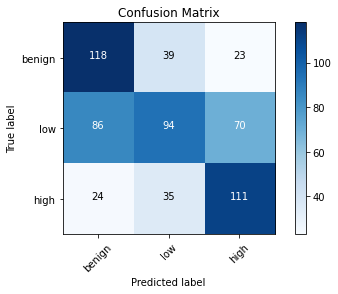

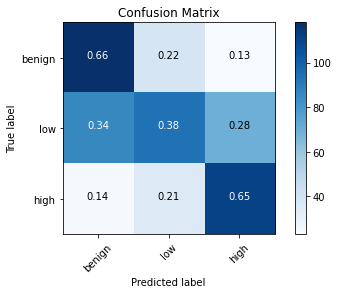

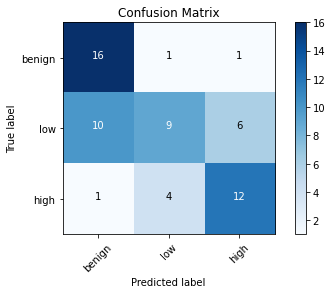

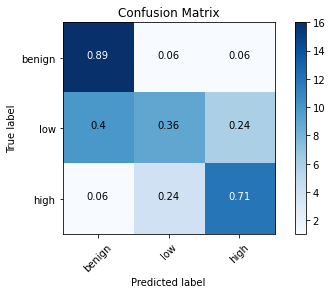

<Figure size 432x288 with 0 Axes>

In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt


print(model_best.predict(x_test))
print(model_best.predict(x_test)[0])
print(np.argmax(model_best.predict(x_test), axis=1) )
print('y_test is ', y_test)
print(np.argmax(y_test, axis=1) )



cm = confusion_matrix(y_true= np.argmax(y_test, axis=1) , y_pred=np.argmax(model_best.predict(x_test), axis=1)  )

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        np.around(cm, decimals=2, out=cm)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


cm_plot_labels = ['benign','low','high']

plot_confusion_matrix(cm=cm, normalize=False, classes=cm_plot_labels, title='Confusion Matrix')   # 
plt.figure()

plot_confusion_matrix(cm=cm, normalize=True, classes=cm_plot_labels, title='Confusion Matrix')   #  
plt.figure()


print('now we do per patient', x_test.shape )
n_tiles, nx, ny, ncol = x_test.shape
x_patient = model_best.predict(x_test)
x_patient = x_patient.reshape( (-1, 10, num_classes)  )
x_patient = np.mean(x_patient, axis=1)
print(x_patient)


y_patient = np.argmax(y_test, axis=1)
print(y_patient.shape)
y_patient = y_patient.reshape( (-1, 10)  )
y_patient = np.mean(y_patient, axis=1)
print(y_patient.shape)
print(y_patient)

cm = confusion_matrix(y_true= y_patient , y_pred=np.argmax(x_patient, axis=1)  )


plot_confusion_matrix(cm=cm, normalize=False, classes=cm_plot_labels, title='Confusion Matrix')   # 
plt.figure()

plot_confusion_matrix(cm=cm, normalize=True, classes=cm_plot_labels, title='Confusion Matrix')   #  
plt.figure()

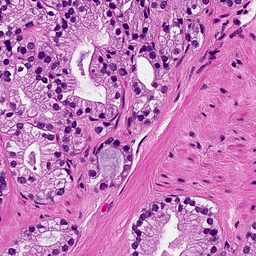

displayed
out of the relu   [[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.21618711e+04 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.32044395e+04 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    5.15209570e+03 7.70113220e+01]
   ...
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.23411331e+01
    0.00000000e+00 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 1.00804298e+02
    1.50560272e+02 0.00000000e+00]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 5.38646660e+01
    7.83899612e+01 0.00000000e+00]]

  [[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    1.82998203e+04 2.39600113e+02]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
    2.00537852e+04 4.44953522e+02]
   [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 8.77292633e+01
    9.49310352e+03 1.54005096e+02]
   ...
   [0.00000000e+00 0.00000000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:139: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.7/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


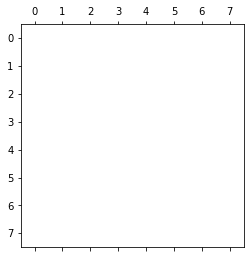

Displayed Heatmap


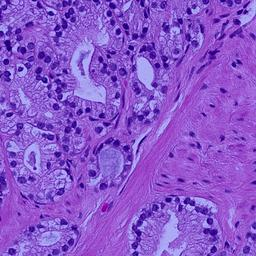

In [ ]:
# Display
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow import keras
from keras.applications.densenet import preprocess_input, decode_predictions


from imutils import paths
#from PIL import Image, ImageFile




#model_builder = keras.applications.xception.Xception      #(include_top=False,  input_shape=(256, 256, 3))
img_size = (256, 256)
#preprocess_input = keras.applications.xception.preprocess_input
#decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = 'relu'     #'conv5_block32_concat'      #"conv5_block32_2_conv"     'bn', 'relu',
#classifier_layer_names = ['avg_pool', 'flatten', 'dense_post_pool', 'predictions']

classifier_layer_names = [ 'avg_pool', 'flatten', 'dense_post_pool', 'dropout', 'predictions']





# # The local path to our target image
img_path = '/content/drive/MyDrive/223B/normal_256_1_new/4271_27776_23296.png'
# img_path = '/content/drive/MyDrive/223B/normal_256_1_new/189_4032_11648.png'
display(Image(img_path))
print('displayed')



# _45696_13440     4+5
# 2978  :  9063_84224_24192     4+5
# 2979  :  9063_9856_11648     4+5
# 2980  :  398_17024_24192     0+0
# 2981  :  398_85120_26880     0+0
# 2982  :  398_28672_14336     0+0
# 2983  :  398_5376_34944     0+0
# 2984  :  398_23296_16128     0+0
# 2985  :  398_86912_28672     0+0
# 2986  :  398_19712_18816     0+0
# 2987  :  398_17024_25984     0+0
# 2988  :  398_100352_10752     0+0
# 2989  :  398_29568_15232     0+0
# 2990  :  4271_89600_28672     3+3
# 2991  :  4271_90496_26880     3+3
# 2992  :  4271_31360_25984
# 2993  :  4271_30464_28672     3+3
# 2994  :  4271_89600_27776     3+3
# 2995  :  4271_26880_23296     3+3
# 2996  :  4271_27776_23296     3+3
# 2997  :  4271_89600_26880     3+3
# 2998  :  4271_91392_26880     3+3
# 2999  :  4271_31360_26880




















def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        print(layer_name)
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) *1000000000000000000 / np.max(heatmap) 
    return heatmap





#######    select an image where the softmax error is very big   e.g. No91    '/content/drive/MyDrive/223B/256_1/256_1_test/5602_157696_32256.png'

img_path_select_image = img_path

# Prepare image
img_array = preprocess_input(get_img_array(img_path_select_image, size=img_size))

print('out of the relu  ', feat_extr_model.predict(img_array))





# Print what the top predicted class is
preds = model_best.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model_best, last_conv_layer_name, classifier_layer_names
)

# Display heatmap
plt.matshow(heatmap)
plt.show()

print('Displayed Heatmap')






######### display the grad_cam

# We load the original image
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))

